# Changes to HCIPostProcAlgo

VIP [PR #328](https://github.com/vortex-exoplanet/VIP/pull/328)

In [1]:
import vip_hci as vip
plots = vip.var.pp_subplots

vip.__version__

'0.9.8'

## load dataset

In [2]:
ds = vip.HCIDataset.load("../datasets/naco_betapic_preproc")

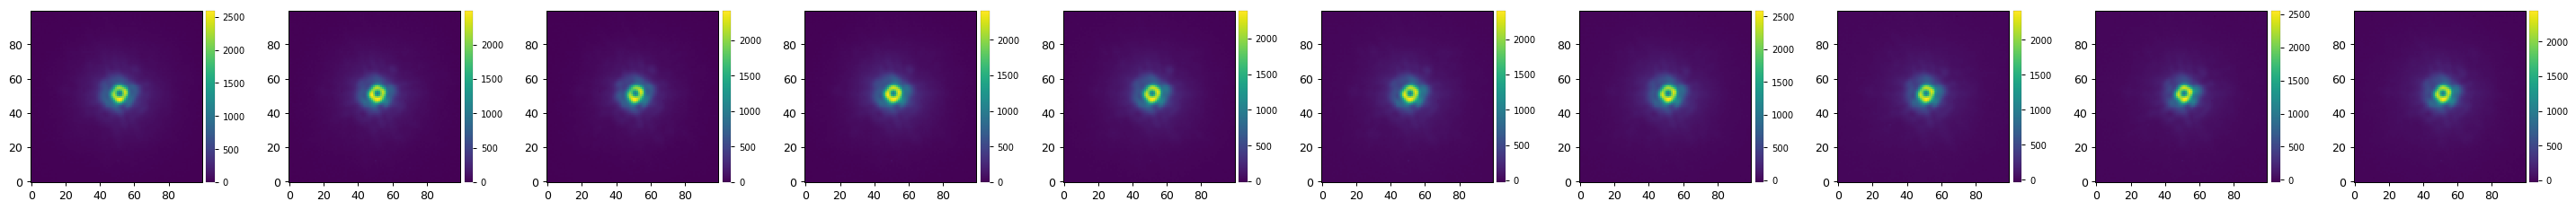

In [3]:
ds.plot()

create a new dataset with an injection:

## Running algorithms
### MedianSub

In [4]:
ams = vip.HCIMedianSub(mode="fullfr")

asize: 1
collapse: median
dataset: None
delta_rot: 1
delta_sep: (0.2, 1)
imlib: opencv
interpolation: lanczos4
mode: fullfr
nframes: 4
radius_int: 0
verbose: True


The algorithms output informations about the computed attributes:

In [5]:
ams.run(ds)

--------------------------------------------------------------------------------
Starting time: 2018-09-27 02:22:03
--------------------------------------------------------------------------------
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.098828
--------------------------------------------------------------------------------
These attributes were just calculated:
	cube_residuals
	cube_residuals_der
	frame_final
The following attributes can be calculated now:
	snr_map	with .make_snr_map()
	detection_map	with .make_snr_map()


That behaviour can be disabled using `verbose=False`.

Note that the methods like `.run()` or `.make_snr_map()` do *not* return anything. Everything should be stored inside the object itself.

The dataset can be specified using the constructor (`vip.HCIMedianSub(ds, mode="fullfr")`), or — as above — to the `.run()` method. As the object keeps track of all the propeties which were calculated, it can *clear* them in case `.run()` is called multiple times, with different datasets.

When one tries to access a property which is not computed yet, a clear error message is shown, pointing the user to the function he might want to call first:

In [6]:
ams.snr_map

AttributeError: The 'snr_map' was not calculated yet. Call 'make_snr_map' first.

In [7]:
ams.make_snr_map()

--------------------------------------------------------------------------------
Starting time: 2018-09-27 02:22:04
--------------------------------------------------------------------------------
S/N map created using 1 processes.
Running time:  0:00:03.023536
--------------------------------------------------------------------------------
These attributes were just calculated:
	snr_map
	detection_map


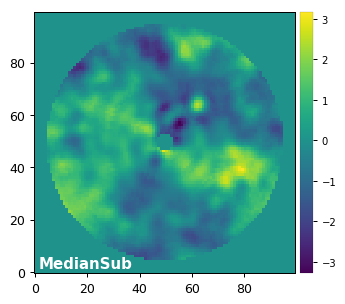

In [8]:
plots(ams.detection_map, label=["MedianSub"])

### PCA

Let's do the same with the other algorithms.

In [9]:
apc = vip.HCIPca(ncomp=10, verbose=False)
apc.run(ds)
apc.make_snr_map()

--------------------------------------------------------------------------------
Starting time: 2018-09-27 02:22:07
--------------------------------------------------------------------------------
Done vectorizing the frames. Matrix shape: (61, 10000)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.133081
--------------------------------------------------------------------------------
Done de-rotating and combining
Running time:  0:00:00.195025
--------------------------------------------------------------------------------
These attributes were just calculated:
	frame_final
	cube_reconstructed
	cube_residuals
	cube_residuals_der
	pcs
The following attributes can be calculated now:
	snr_map	with .make_snr_map()
	detection_map	with .make_snr_map()
--------------------------------------------------------------------------------
Starting time: 2018-09-27 02:22:07
--------------------------------------------------------------------------------
S/N map created using 1 processes.

### LOCI

In [10]:
alc = vip.HCILoci(dist_threshold=90, verbose=False)
alc.run(ds, verbose=False)
alc.make_snr_map(verbose=False)

### ANDROMEDA

andromeda is a bit different, as the SNR map is calculated directly by the `.run()` method. The new API makes that clear:

In [11]:
aand = vip.HCIAndromeda(iwa=3, owa=50, nsmooth_snr=2, min_sep=0.6, verbose=True)
aand.run(ds, verbose=True, nproc=1)

annuli_width: 1.0
dataset: None
ditimg: 1.0
ditpsf: None
fast: False
filtering_fraction: 0.25
homogeneous_variance: True
iwa: 3
min_sep: 0.6
multiply_gamma: True
nsmooth_snr: 2
opt_method: lsq
oversampling_fact: 0.5
owa: 50
precision: 50
roa: 2.0
tnd: 1.0
total: False
verbose: True
Applying the high-pass filter on cube frames:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Using these user parameters, 28 annuli will be processed, from a separation of 3 to 31 pixels.
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:17
These attributes were just calculated:
	final_frame
	contrast_map
	likelihood_map
	snr_map
	stdcontrast_map
	snr_map_notnorm
	stdcontrast_map_notnorm
	ext_radius
	detection_map


### results

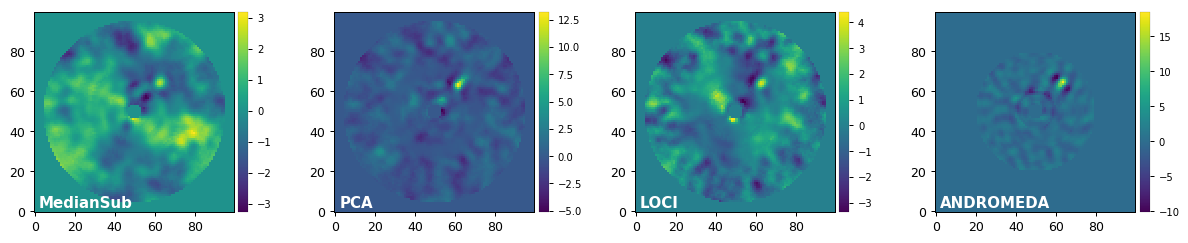

In [12]:
plots(ams.detection_map, apc.detection_map, alc.detection_map, aand.detection_map,
      label=["MedianSub", "PCA", "LOCI", "ANDROMEDA"])

## Creating a new algorithm

Various new functions were added to the `HCIPostProcAlgo` superclass. The actual algorithm classes, like `HCIMedianSub` stay slim and clear.

Let's build a new algorithm class, to see how it works. Let's use the simple derotate-median approach to ADI.

In [13]:
from vip_hci.conf.utils_conf import algo_calculates_decorator as calculates
from vip_hci.hci_postproc import HCIPostProcAlgo

In [14]:
class HCIDerotateMedian(HCIPostProcAlgo):
    # the __init__ should take:
    #   - a dataset, which can be None
    #   - all parameters which are algorithm-specific. They should have default
    #     values.
    # here, we use the nonsense parameter `colour` for demonstration purposes,
    # because our algorithm does not really have a meaningful parameter...
    def __init__(self, dataset=None, colour="red"):
        # we have to call the superclass' __init__, just passing locals() to it.
        # locals() contains the parameters passed to the function.
        super(HCIDerotateMedian, self).__init__(locals())
        # the HCIPostProcAlgo's __init__ takes care of saving the parameters.
    
    # the `run` method should be decorated with @calculates. It describes what
    # attributes the function computes. That is required e.g. for error messages.
    @calculates("frame_final", "colour_awesome")
    # the run method needs `dataset`, `nproc` and `verbose`, but you can add
    # other parameters if necessary. Those should not be related to the algo
    # itself, as they will not be stored in the object. Think of e.g. `debug`...
    def run(self, dataset=None, nproc=1, verbose=True,
            awesomeness=3):
        
        # you should verify the dataset like this, to make sure the user provided
        # either one with the __init__, or one with the `run()`.
        dataset = self._get_dataset(dataset, verbose)

        # algorithm parameters (from init) are stored as attributes:
        colour_awesome = "*"*awesomeness + self.colour.upper() + "*"*awesomeness
        
        if verbose:
            print("processing...")
        
        # as we want to use HCIDataset.derotate(), and that function *modifies*
        # the dataset, we create a backup copy first. Note that this is not
        # memory efficient.
        dataset_derot = dataset.copy()
        dataset_derot.derotate()
        frame = dataset_derot.collapse(mode="median")  # HCIFrame object
        # copy FWHM into HCIFrame:
        frame.fwhm = dataset_derot.fwhm
        
        # save the result:
        self.colour_awesome = colour_awesome
        self.frame_final_object = frame
        self.frame_final = frame.image  # ndarray, as required by e.g. make_snr_map

        
        # do NOT return anything.
        
    # the HCIPostProcAlog superclass already provides a `make_snr_map`, so we do
    # not have to overwrite it.

The algorithm will have a rather poor performance, so let's inject a brighter companion into the previous dataset:

In [15]:
dsi = ds.copy()
dsi.inject_companions(flux=300, rad_dists=30)

Branch 1:
	(X,Y)=(79.00, 49.00) at 0.82 arcsec (30.00 pxs)
Coordinates of the injections stored in self.injections_yx


set up the algorithm:

In [16]:
a = HCIDerotateMedian(colour="blue")

colour: blue
dataset: None


This should fail, as `colour_awesome` is not calculated yet — note the pretty error message:

In [17]:
a.colour_awesome

AttributeError: The 'colour_awesome' was not calculated yet. Call 'run' first.

This should also fail, as no dataset was provided (neither to the constructor, nor to `run()`):

In [18]:
a.run()

ValueError: no dataset specified!

pass the dataset with the fake injection:

In [19]:
a.run(dsi)
a.make_snr_map(method="xpx")

processing...
Cube successfully derotated
Cube successfully collapsed
Frame shape: (100, 100)
These attributes were just calculated:
	frame_final
	colour_awesome
The following attributes can be calculated now:
	snr_map	with .make_snr_map()
	detection_map	with .make_snr_map()
--------------------------------------------------------------------------------
Starting time: 2018-09-27 02:23:58
--------------------------------------------------------------------------------
S/N map created using 1 processes.
Running time:  0:00:37.721850
--------------------------------------------------------------------------------
These attributes were just calculated:
	snr_map
	detection_map


In [20]:
a.colour_awesome

'***BLUE***'

Let's compare it to the Median Subtraction algorithm. We can just call `run()` on our HCIMedianSub object again, supplying a different dataset. All *calculated* results, e.g. `snr_map`, are cleared, as expected.

In [21]:
ams.run(dsi, verbose=False)
ams.make_snr_map(method="xpx", verbose=False)

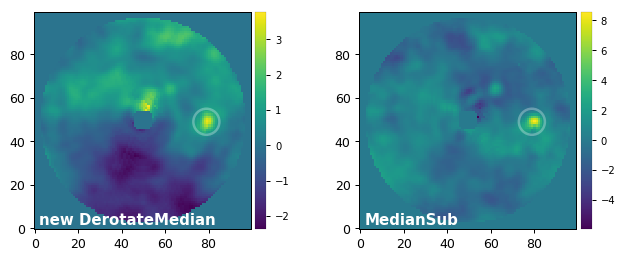

In [22]:
plots(a.snr_map, ams.snr_map,
      label=["new DerotateMedian", "MedianSub"],
      circle=dsi.injections_yx[0][::-1], circlealpha=0.3)

While the performance is clearly low, we still managed to recover the companion. And the algorithm was just 2 lines of VIP ;)